<a href="https://colab.research.google.com/github/ngupta23/medium_articles/blob/main/time_series/pycaret/pycaret_ts_arima_000_0000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install & Import Library

In [17]:
!pip install pycaret-ts-alpha

In [2]:
import pandas as pd
import seaborn as sns
from pycaret.datasets import get_data
from pycaret.internal.pycaret_experiment import TimeSeriesExperiment

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Get Data and Setup PyCaret Experiment

In [3]:
#### Get data ----
y = get_data("1", folder="time_series/random_walk", verbose=False)

In [4]:
exp = TimeSeriesExperiment()
exp.setup(data=y, seasonal_period=1, fh=30, session_id=42)

,Description,Value
0,session_id,42
1,Original Data,"(340, 1)"
2,Missing Values,False
3,Transformed Train Set,"(310,)"
4,Transformed Test Set,"(30,)"
5,Fold Generator,ExpandingWindowSplitter
6,Fold Number,3
7,Enforce Prediction Interval,False
8,Seasonal Period Tested,1
9,Seasonality Detected,False


## EDA

In [5]:
exp.plot_model()

In [6]:
exp.plot_model(plot="acf")
exp.plot_model(plot="pacf")

## Helper functions using PyCaret's Time Series Module

In [7]:
def summarize_model(model):
  """
  Provides statistical summary for some statistical models
  """
  # Statistical Summary Table
  try:
    print(model.summary())
  except:
    print("Summary does not exist for this model.")

In [8]:
def get_residual_properties(model):
  """
  Plots and displays variance of residuals
  """
  #### Residuals ----
  try:
    plot_data = exp.plot_model(model, plot="residuals", return_data=True)
    residuals = plot_data['data']
    residuals_var = residuals.std(ddof=0)**2
    print(f"Variance of Residuals: {residuals_var}")
  except:
    print("Residuals can not be extracted for this model.")


In [9]:
def plot_predictions(model):
  """
  Plots out-of-sample and in-sample predictions
  """
  # Out-of-Sample Forecast
  exp.plot_model(model)
  
  # In-Sample Forecast
  exp.plot_model(model, plot="insample")

## Train & Test Data Properties

In [10]:
# Get Train Data Properties
y_train = exp.get_config("y_train")
print(f"Train Start Index: {y_train.index.min()}\nTrain End Index: {y_train.index.max()}")
print(f"Mean Value of Training Dataset: {y_train.mean()}")

# Get Test Data Properties
y_test = exp.get_config("y_test")
print(f"Test Start Index: {y_test.index.min()}\nTest End Index: {y_test.index.max()}")

Train Start Index: 0
Train End Index: 309
Mean Value of Training Dataset: 186.59657396255017
Test Start Index: 310
Test End Index: 339


## ARIMA Model (Overview)

In [11]:
# Talk about hyperparameters (p, d, q) x (P, D, Q, S)
# Talk about include_intercept
model_class = exp.models(internal=True).loc["arima"]["Class"]

## Get help on model parameters (important ones summarized below)
# ?model_class

**order:** iterable or array-like, shape=(3,), optional (default=(1, 0, 0))
    The (p,d,q) order of the model for the number of AR parameters,
    differences, and MA parameters to use.

**seasonal_order:** array-like, shape=(4,), optional (default=(0, 0, 0, 0))
    The (P,D,Q,s) order of the seasonal component of the model for the
    AR parameters, differences, MA parameters, and periodicity.

**with_intercept:** bool, optional (default=True)
    Whether to include an intercept term. Default is True.

## Baseline Model (Grand Means)

### Theoretical Calculations

In [12]:
train_data = pd.DataFrame({"y":y_train})
train_data['preds'] = y_train.mean()
train_data['split'] = "Train"

test_data = pd.DataFrame({'y': y_test})
test_data['preds'] = y_train.mean()
test_data['split'] = "Test"

data = pd.concat([train_data, test_data])
data.reset_index(inplace=True)

[Text(0.5, 1.0, 'Theoretical Predictions')]

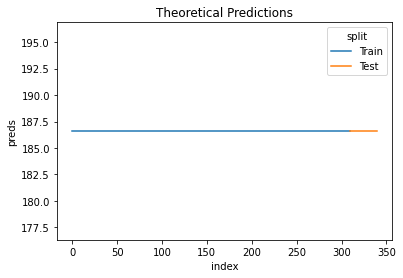

In [13]:
sns.lineplot(data=data, x="index", y="preds", hue="split").set(title="Theoretical Predictions")

But what about the confidence intervals?
95% Prediction Intervals Multiplier = 1.96 

**Confidence interval**

    = Mean +/- 1.96 * Std of Residuals
    = 186.6 +/- 1.96 * sqrt(19.84)
    = 186.6 +/- 8.73
    = 177.87 to 195.33          

### Now let's build this model & compate to Theory

In [14]:
model1 = exp.create_model("arima", order=(0, 0, 0), seasonal_order=(0, 0, 0, 0))

,cutoff,MAE,RMSE,MAPE,SMAPE,R2
0,219.0,7.0263,7.1643,0.0366,0.0373,-25.1990
1,249.0,5.6655,6.1631,0.0295,0.0300,-5.4542
2,279.0,4.8776,5.1497,0.0255,0.0258,-8.7198
Mean,NaN,5.8565,6.1590,0.0305,0.0310,-13.1243
SD,NaN,0.8875,0.8225,0.0046,0.0047,8.6415


In [15]:
summarize_model(model1)
get_residual_properties(model1)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  310
Model:                        SARIMAX   Log Likelihood                -902.949
Date:                Sun, 14 Nov 2021   AIC                           1809.898
Time:                        13:54:54   BIC                           1817.371
Sample:                             0   HQIC                          1812.885
                                - 310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    186.5966      0.258    722.443      0.000     186.090     187.103
sigma2        19.8380      2.113      9.386      0.000      15.696      23.980
Ljung-Box (L1) (Q):                 296.06   Jarque-

Variance of Residuals: 19.838012211345678


**So the intercept in the model summary represents the Mean of the training data in this case and the sigma2 represents the variance of the model residuals.**

What about the model predictions?

In [16]:
plot_predictions(model1)

**The calculations match exactly with the theoretical calculations.** Hopefully this model has given us a good starting point to understand the inner workings of an ARIMA model. In the next set of FAQ's we will start covering the other parameters one by one and see the impact that they have on the model's behavior.